## Imports

In [ ]:
# Version 3.0
!pip install tabulate itertools
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Add this import
import pandas as pd
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
from tabulate import tabulate
import itertools
import networkx as nx
import numpy as np

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


## Graph Generation Functions

In [44]:
def find_connected_subgraph(G, size=4):
    """Find a connected subgraph of specified size"""
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        if len(subgraph) >= size:
            start_node = np.random.choice(list(subgraph.nodes()))
            nodes = list(nx.bfs_tree(subgraph, start_node))[:size]
            return nodes
    return None

def generate_graph(num_nodes=100, edge_prob=0.05):
    """Generate a random graph ensuring it has at least one connected component of size 4"""
    while True:
        G = nx.erdos_renyi_graph(n=num_nodes, p=edge_prob)
        connected_nodes = find_connected_subgraph(G, size=4)
        if connected_nodes is not None:
            return G, connected_nodes

## Feature Computation Functions

In [45]:
# Define feature names to match the 46 output features
FEATURE_NAMES = [
    # Node-specific features (9 features for each of 4 nodes = 36)
    *[f"Node{i+1}_{metric}" for i in range(4) for metric in [
        'Degree', 'Clustering', 'NeighborDeg', 'Betweenness', 
        'Closeness', 'PageRank', 'CoreNumber', 'LocalEff', 'Eigenvector'
    ]],
    
    # Global features (10)
    'GraphDensity',
    'AvgClustering',
    'AvgPathLength',
    'DegreeAssortativity',
    'Transitivity',
    'ConnectedComponents',
    'MaxDegree',
    'MinDegree',
    'AvgDegree',
    'GlobalEfficiency'
]

def compute_features(G, nodes):
    """
    Compute graph features with enhanced normalization and reliability.
    """
    if nodes is None or len(nodes) != 4:
        raise ValueError("Must provide exactly 4 nodes for feature computation")
    
    features = []
    n_nodes = len(G)

    def normalize_metric_dict(metric_dict, min_val=0.1):
        """Normalize dictionary values to [min_val, 1] range."""
        values = np.array(list(metric_dict.values()))
        min_metric = np.min(values)
        max_metric = np.max(values)
        
        if max_metric == min_metric:
            return {k: min_val for k in metric_dict.keys()}
            
        normalized = {
            k: min_val + (v - min_metric) * (1 - min_val) / (max_metric - min_metric)
            for k, v in metric_dict.items()
        }
        return normalized
    
    # Pre-compute and normalize all centrality metrics
    try:
        # Compute and normalize basic centrality metrics
        betweenness = normalize_metric_dict(nx.betweenness_centrality(G))
        closeness = normalize_metric_dict(nx.closeness_centrality(G))
        pagerank = normalize_metric_dict(nx.pagerank(G))
        core_numbers = normalize_metric_dict(nx.core_number(G))
        degrees = normalize_metric_dict(dict(G.degree()))
        
        # Enhanced clustering computation and normalization
        clustering = nx.clustering(G)
        clustering = normalize_metric_dict(clustering)
        
        # Handle eigenvector centrality for largest component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        eigenvector = nx.eigenvector_centrality_numpy(subgraph)
        min_eigen = min(eigenvector.values())
        eigenvector.update({n: min_eigen for n in G.nodes() if n not in eigenvector})
        eigenvector = normalize_metric_dict(eigenvector)
        
    except Exception as e:
        print(f"Error computing centrality metrics: {str(e)}")
        raise
    
    # Process each node
    for node in nodes:
        # Calculate neighbor-based metrics
        neighbors = list(G.neighbors(node))
        avg_neighbor_degree = (
            np.mean([degrees[n] for n in neighbors]) 
            if neighbors else 0.1  # Use minimum value if no neighbors
        )
        
        # Compile node features
        node_features = [
            degrees[node],
            clustering[node],
            avg_neighbor_degree,
            betweenness[node],
            closeness[node],
            pagerank[node],
            core_numbers[node],
            compute_local_efficiency(G, node),
            eigenvector[node]
        ]
        features.extend(node_features)
    
    # Compute and normalize global features
    global_features = [
        nx.density(G),
        nx.average_clustering(G),
        nx.average_shortest_path_length(G) / n_nodes if nx.is_connected(G) else 0.1,
        nx.degree_assortativity_coefficient(G),
        nx.transitivity(G),
        len(list(nx.connected_components(G))) / n_nodes,
        max(degrees.values()),
        min(degrees.values()),
        np.mean(list(degrees.values())),
        nx.global_efficiency(G)
    ]
    
    # Normalize global features
    global_features = normalize_metric_dict(
        {str(i): v for i, v in enumerate(global_features)}
    ).values()
    
    features.extend(global_features)
    return torch.tensor(features, dtype=torch.float32)

def prepare_node_features(G):
    """Prepare node features including removal flag"""
    num_nodes = G.number_of_nodes()
    # Basic features for each node (5 base features + 1 removal flag)
    features = torch.zeros(num_nodes, 6)
    
    for i in range(num_nodes):
        features[i] = torch.tensor([
            G.degree[i],
            nx.clustering(G, i),
            np.mean([G.degree[n] for n in G.neighbors(i)]) if list(G.neighbors(i)) else 0,
            list(nx.betweenness_centrality(G).values())[i],
            list(nx.closeness_centrality(G).values())[i],
            0  # Removal flag, will be set later
        ])
    return features

def prepare_edge_index(G):
    """Convert NetworkX graph edges to PyG edge index"""
    return torch.tensor([[e[0], e[1]] for e in G.edges()]).t().contiguous()

def calculate_feature_accuracy(predicted, target, threshold=0.1):
    """
    Calculate accuracy for each feature based on relative error.
    
    Args:
        predicted (torch.Tensor): Predicted features
        target (torch.Tensor): Target features
        threshold (float): Threshold for considering a prediction accurate
        
    Returns:
        torch.Tensor: Binary accuracy for each feature
    """
    # Avoid division by zero
    epsilon = 1e-8
    
    # Calculate relative error
    relative_error = torch.abs(predicted - target) / (torch.abs(target) + epsilon)
    
    # Convert to binary accuracy (1 if error is below threshold, 0 otherwise)
    accuracy = (relative_error < threshold).float()
    
    return accuracy

## Data Processing Functions

In [46]:
def process_graph_data(G, nodes_to_remove):
    """Process a graph to create training data"""
    # Original graph features
    original_features = compute_features(G, nodes_to_remove)
    
    # Create residual graph
    residual_G = G.copy()
    residual_G.remove_nodes_from(nodes_to_remove)
    
    # Get features for residual graph
    largest_component = max(nx.connected_components(residual_G), key=len)
    residual_G_main = residual_G.subgraph(largest_component)
    residual_features = compute_features(residual_G_main, 
                                       list(residual_G_main.nodes())[:4] if len(residual_G_main) >= 4 else None)
    
    # Create PyG data object
    data = Data(
        x=prepare_node_features(G),
        edge_index=prepare_edge_index(G),
        removed_nodes=torch.tensor(nodes_to_remove),
        original_features=original_features,
        residual_features=residual_features
    )
    return data

def evaluate_predictions(model, data):
    """
    Evaluate model predictions and print results
    """
    model.eval()
    with torch.no_grad():
        output = model(data)
        loss = compute_loss(output, data)
        accuracy = calculate_accuracy(output, data)
        
        print(f"Evaluation Results:")
        print(f"Loss: {loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
    return output, loss, accuracy

def compute_loss(output, data):
    """Modified loss function with dynamic weighting"""
    predicted = output.squeeze(0)
    target = data.original_features
    
    # Create dynamic weights based on feature performance
    weights = torch.ones_like(target)
    epsilon = 1e-8  # Prevent division by zero
    
    # Higher weights for features with larger errors
    with torch.no_grad():
        errors = torch.abs(predicted - target)
        weights = 1.0 + torch.log1p(errors + epsilon)
    
    return torch.mean(weights * (predicted - target) ** 2)

def compute_local_efficiency(G, node):
    """
    Enhanced local efficiency computation with better handling of edge cases.
    """
    neighbors = list(G.neighbors(node))
    if not neighbors:
        return 0.1  # Minimum value instead of 0
        
    subgraph = G.subgraph(neighbors)
    n = len(subgraph)
    
    if n < 2:
        return 0.1
        
    try:
        # Try direct calculation first
        eff = nx.global_efficiency(subgraph)
        return max(eff, 0.1)  # Ensure minimum value
    except:
        # Fallback to manual calculation
        total_paths = 0
        valid_paths = 0
        
        for u in neighbors:
            for v in neighbors:
                if u != v:
                    total_paths += 1
                    try:
                        path = nx.shortest_path_length(subgraph, u, v)
                        valid_paths += 1/path if path > 0 else 0
                    except nx.NetworkXNoPath:
                        continue
                        
        if total_paths == 0:
            return 0.1
            
        return max(valid_paths / total_paths, 0.1)

## Model Definition

In [47]:
class EnhancedGNNModel(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim=128):
        super().__init__()
        self.conv1 = GCNConv(node_feature_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        
        # Add batch normalization layers
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        
        self.dropout = nn.Dropout(0.2)
        
        # Adjusted MLPs for larger hidden dimension
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 9)  # 9 features per node
        )
        
        self.global_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 10)  # 10 global features
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long)
        
        # Apply convolutions with batch norm
        x = self.bn1(self.conv1(x, edge_index).relu())
        x = self.dropout(x)
        x = self.bn2(self.conv2(x, edge_index).relu())
        x = self.dropout(x)
        x = self.bn3(self.conv3(x, edge_index).relu())
        
        # Process features for the 4 selected nodes (9 features each = 36)
        node_features = self.node_mlp(x)
        selected_nodes = data.removed_nodes
        selected_features = node_features[selected_nodes]
        selected_features = selected_features.view(-1)  # Flatten to 36 features
        
        # Global features (10 features)
        global_x = global_mean_pool(x, batch)
        global_features = self.global_mlp(global_x).squeeze(0)
        
        # Combine to match target shape (36 + 10 = 46 features)
        combined_features = torch.cat([selected_features, global_features])
        return combined_features.unsqueeze(0)  # Add batch dimension

In [48]:
def train_model(model, data, num_epochs=300):
    """Train model with accuracy visualization"""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=15, min_lr=1e-4, verbose=True
    )
    
    feature_accuracies = []
    training_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        output = model(data)
        loss = compute_loss(output, data)
        
        accuracies = calculate_feature_accuracy(
            output.squeeze(0), 
            data.original_features
        )
        feature_accuracies.append(accuracies.detach().cpu())
        training_accuracies.append(accuracies.mean().item())
        
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss = {loss.item():.4f}, '
                  f'LR = {optimizer.param_groups[0]["lr"]:.6f}, '
                  f'Acc = {accuracies.mean().item():.4f}')
    
    # Plot training progress
    plt.figure(figsize=(12, 6))
    plt.plot(training_accuracies, 'b-', label='Average Accuracy')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Target')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Progress')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    final_accuracies = torch.stack(feature_accuracies).mean(dim=0)
    return final_accuracies

def display_results(avg_accuracies):
    """Display feature accuracies in table format"""
    # Create results dataframe
    results_df = pd.DataFrame({
        'Feature': FEATURE_NAMES,
        'Accuracy': [f"{acc:.4f}" for acc in avg_accuracies]
    }).sort_values('Accuracy', ascending=False)
    
    # Print results
    print("\nFeature Prediction Accuracies:")
    print(tabulate(results_df, headers='keys', tablefmt='pipe', showindex=False))

## Execution

Epoch 0: Loss = 0.3522, LR = 0.005000, Acc = 0.0000
Epoch 10: Loss = 0.0259, LR = 0.005000, Acc = 0.2174
Epoch 20: Loss = 0.0118, LR = 0.005000, Acc = 0.2826
Epoch 30: Loss = 0.0062, LR = 0.005000, Acc = 0.3696
Epoch 40: Loss = 0.0017, LR = 0.005000, Acc = 0.5435
Epoch 50: Loss = 0.0033, LR = 0.005000, Acc = 0.6522
Epoch 60: Loss = 0.0011, LR = 0.002500, Acc = 0.7609
Epoch 70: Loss = 0.0013, LR = 0.002500, Acc = 0.7826
Epoch 80: Loss = 0.0010, LR = 0.002500, Acc = 0.7174
Epoch 90: Loss = 0.0012, LR = 0.002500, Acc = 0.7391
Epoch 100: Loss = 0.0009, LR = 0.002500, Acc = 0.8261
Epoch 110: Loss = 0.0014, LR = 0.001250, Acc = 0.7174
Epoch 120: Loss = 0.0007, LR = 0.000625, Acc = 0.8261
Epoch 130: Loss = 0.0022, LR = 0.000625, Acc = 0.6739
Epoch 140: Loss = 0.0009, LR = 0.000313, Acc = 0.7826
Epoch 150: Loss = 0.0005, LR = 0.000313, Acc = 0.8043
Epoch 160: Loss = 0.0007, LR = 0.000156, Acc = 0.8261
Epoch 170: Loss = 0.0014, LR = 0.000156, Acc = 0.7826
Epoch 180: Loss = 0.0006, LR = 0.000100

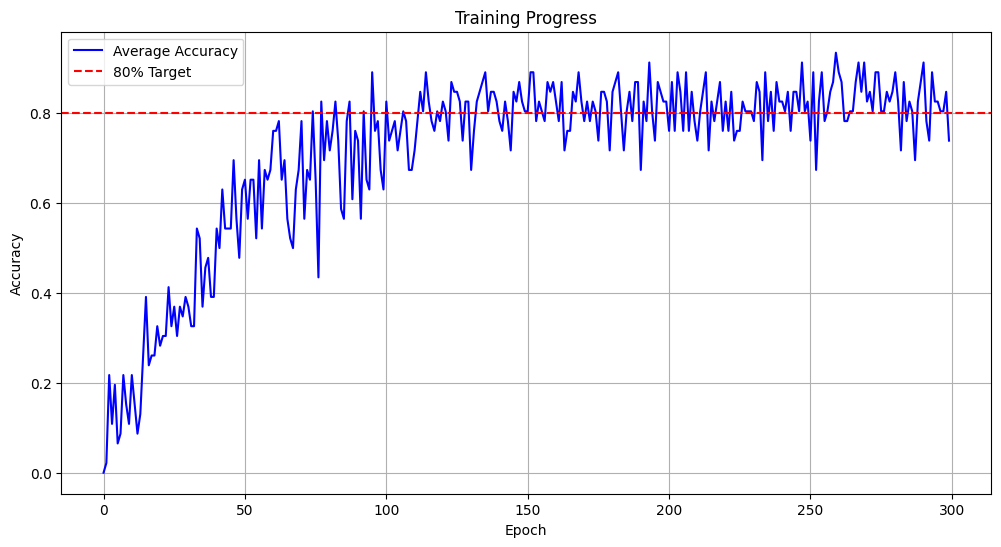


Feature Prediction Accuracies:
| Feature             |   Accuracy |
|:--------------------|-----------:|
| MaxDegree           |     0.9533 |
| AvgDegree           |     0.93   |
| GlobalEfficiency    |     0.92   |
| DegreeAssortativity |     0.9133 |
| Node2_CoreNumber    |     0.91   |
| Node3_Closeness     |     0.91   |
| Node3_CoreNumber    |     0.9067 |
| Node1_CoreNumber    |     0.9    |
| AvgPathLength       |     0.89   |
| Transitivity        |     0.8867 |
| MinDegree           |     0.8833 |
| Node3_NeighborDeg   |     0.8833 |
| Node2_Closeness     |     0.8833 |
| ConnectedComponents |     0.8767 |
| AvgClustering       |     0.8767 |
| Node1_Closeness     |     0.8733 |
| GraphDensity        |     0.8733 |
| Node1_NeighborDeg   |     0.8733 |
| Node3_PageRank      |     0.83   |
| Node2_PageRank      |     0.8267 |
| Node4_CoreNumber    |     0.8267 |
| Node1_PageRank      |     0.8167 |
| Node3_Degree        |     0.8133 |
| Node1_Degree        |     0.81   |
| Node

In [49]:
# Generate graph and prepare data
G, selected_nodes = generate_graph(num_nodes=100, edge_prob=0.05)
data = process_graph_data(G, selected_nodes)

# Initialize and train model
model = EnhancedGNNModel(node_feature_dim=6, hidden_dim=128)
avg_accuracies = train_model(model, data)

# Display results table
display_results(avg_accuracies)